This notebook will implement anomaly detection on the credit card fraud dataset.

See it on Kaggle at this link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [ ]:
import pandas as pd

file_path = f"{path}/creditcard.csv"
df = pd.read_csv(file_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
"""
Split into test & train + normalize
"""
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
"""
Obtain normal & anomalous sets (already scaled!)
Fraud = 1
"""
X_train_normal = X_train_scaled[y_train == 0]
X_train_anomalous = X_train_scaled[y_train == 1]

y_train_normal = y_train[y_train == 0]
y_train_anomalous = y_train[y_train == 1]

X_test_normal = X_test_scaled[y_test == 0]
X_test_anomalous = X_test_scaled[y_test == 1]

y_test_normal = y_test[y_test == 0]
y_test_anomalous = y_test[y_test == 1]

print(len(X_train_normal), len(y_train_normal), "and", type(X_train_normal))
print(len(X_train_anomalous), len(y_train_anomalous), "and", type(X_train_anomalous))

227451 227451 and <class 'numpy.ndarray'>
394 394 and <class 'numpy.ndarray'>


Other anomaly detection techniques:
- LabelEncoder + Support Vector Classifier, as [here](https://www.kaggle.com/code/youssefelbadry10/credit-card-fraud-detection)
- Isolation Forest, as [here](https://www.kaggle.com/code/krippanandhini/credit-card-fraud-detection).
- Random Forest Classifier, as [here](https://www.kaggle.com/code/savird/credit-card-fraud-rf)
- Something else [here](https://www.kaggle.com/code/joparga3/in-depth-skewed-data-classif-93-recall-acc-now)?

Resource to learn:
- [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest).


Cannot believe the below component experiment took 40 minutes 58 seconds to run.

I will subsequently try PCA to make things more efficient.

In any case, it is pretty interesting to analyze various criterion for model error, being the [Akaik Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) (AIC) and [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (BIC).

Both compute variants of model likelihood, with a small value being better!

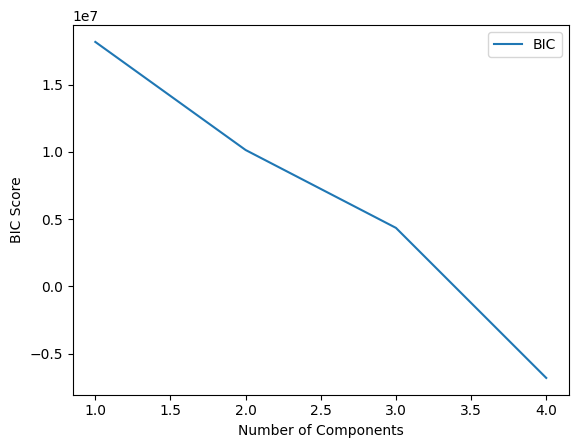

In [ ]:
"""
Clustering using gaussian mixture model
"""
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

n_components = range(1, 5) # Test different number of components
bic_scores = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_train_normal)
    bic_scores.append(gmm.bic(X_train_normal))

plt.plot(n_components, bic_scores, label='BIC')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.legend()

plt.show()

In [ ]:
"""
Using results from experiment to train GMM
"""
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

gmm = GaussianMixture(n_components=9, random_state=42)
gmm.fit(X_train_normal)

print("BIC: ", gmm.bic(X_train_normal))

BIC:  -10145525.17066855


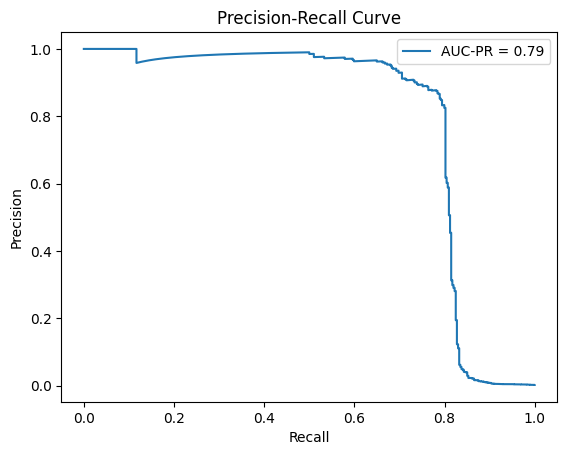

AUC-PR: 0.7897361048982947


In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

normal_probabilities = gmm.score_samples(X_train_normal)
anomalous_probabilities = gmm.score_samples(X_train_anomalous)

all_probabilities = np.concatenate([normal_probabilities, anomalous_probabilities])
all_labels = np.concatenate([np.zeros(len(normal_probabilities)), np.ones(len(anomalous_probabilities))])

# Calculate precision, recall, and AUC-PR
precision, recall, _ = precision_recall_curve(all_labels, all_probabilities * -1)  # Multiplying probabilities by -1 for anomalies
auc_score = auc(recall, precision)

# Plot the PR curve
plt.plot(recall, precision, label=f'AUC-PR = {auc_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Print the AUC-PR score
print(f"AUC-PR: {auc_score}")

Finally, an interesting visualization...

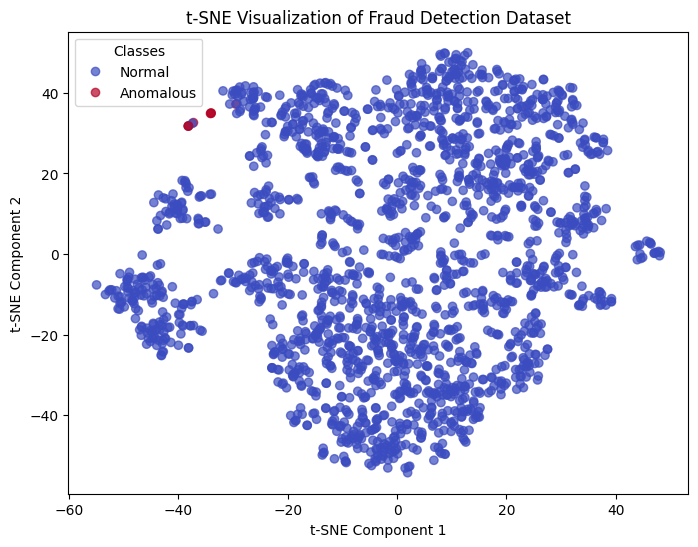

In [ ]:
"""
T-SNE for Visualization
"""
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Combine normal and anomalous data for t-SNE visualization
X_all = np.concatenate([X_train_normal, X_train_anomalous], axis=0)
y_all = np.concatenate([y_train_normal, y_train_anomalous], axis=0)

# Apply PCA to reduce dimensions to a smaller size (e.g., 10 or 15 components)
pca = PCA(n_components=15, random_state=42)  # Reduce to 15 components
X_all_pca = pca.fit_transform(X_all)

# Downsample the data after applying PCA
n_samples = 2000  # Example number of samples to use
indices = np.random.choice(X_all_pca.shape[0], size=n_samples, replace=False)
X_all_pca_downsampled = X_all_pca[indices]
y_all_downsampled = y_all[indices]

# Apply t-SNE to reduce the features from 30 to 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_all_pca_downsampled)

# Plotting the t-SNE result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_all_downsampled, cmap='coolwarm', alpha=0.7)
plt.title('t-SNE Visualization of Fraud Detection Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add a legend
legend_elements = scatter.legend_elements()
plt.legend(handles=legend_elements[0], labels=["Normal", "Anomalous"], title="Classes")
plt.show()

Next, we will deploy a classic anomaly detection algorithm - **Isolation Forest**, using scikit-learn.

Seeing its output, it is much faster & better...however the precision of anomaly detection is rather poor, even though recall is good - so too many false positives - something we do not want for bank fraud detection!

In [ ]:
"""
Training Isolation Forest Model
"""
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score

X_train_combined = np.vstack([X_train_normal, X_train_anomalous])
y_train_combined = np.hstack([y_train_normal, y_train_anomalous])

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.1, random_state=42)  # Set contamination rate as 10%

# Fit the model to the training data
iso_forest.fit(X_train_combined)

# Predict the labels for the training data
y_train_pred = iso_forest.predict(X_train_combined)
# Isolation Forest predicts -1 for anomalies and 1 for normal
y_train_pred = np.where(y_train_pred == -1, 1, 0)  # Convert to binary: 1 for fraud, 0 for normal

# Evaluate the model on the training set
print("Training set performance:")
print(classification_report(y_train_combined, y_train_pred))
print("Training accuracy:", accuracy_score(y_train_combined, y_train_pred))

# Now, let's predict on the test data
X_test_combined = np.vstack([X_test_normal, X_test_anomalous])
y_test_combined = np.hstack([y_test_normal, y_test_anomalous])

y_test_pred = iso_forest.predict(X_test_combined)
y_test_pred = np.where(y_test_pred == -1, 1, 0)  # Convert to binary: 1 for fraud, 0 for normal

# Evaluate the model on the test set
print("\nTest set performance:")
print(classification_report(y_test_combined, y_test_pred))
print("Test accuracy:", accuracy_score(y_test_combined, y_test_pred))

Training set performance:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    227451
           1       0.02      0.89      0.03       394

    accuracy                           0.90    227845
   macro avg       0.51      0.89      0.49    227845
weighted avg       1.00      0.90      0.95    227845

Training accuracy: 0.9013320459084027

Test set performance:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     56864
           1       0.02      0.89      0.03        98

    accuracy                           0.90     56962
   macro avg       0.51      0.90      0.49     56962
weighted avg       1.00      0.90      0.95     56962

Test accuracy: 0.9025315122362276


In [ ]:
"""
Winning model: the gradient boosted tree classifier!!
"""
import xgboost as xgb

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=len(y_train_normal) / len(y_train_anomalous),
    random_state=42
)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model on TEST DATASET
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: tune the threshold to improve precision/recall balance
threshold = 0.15
y_pred_threshold = (y_pred_prob > threshold).astype(int)

print("Classification Report with adjusted threshold:")
print(classification_report(y_test, y_pred_threshold))

# Check accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.99      0.83      0.90        98

    accuracy                           1.00     56962
   macro avg       0.99      0.91      0.95     56962
weighted avg       1.00      1.00      1.00     56962

Classification Report with adjusted threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.87      0.90        98

    accuracy                           1.00     56962
   macro avg       0.97      0.93      0.95     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9996839998595555


---

Basic experiment of a simple GMM from scratch in JAX:

A brief summary:

1. Initialization
- Randomly initialize means, covariances, and weights of Gaussian components.

2. Expectation-Maximization (EM) Algorithm
- E-Step: Compute the probability (responsibilities) of each point belonging to each Gaussian.
- M-Step: Update means, covariances, and weights based on responsibilities
- Repeat until convergence.

3. Anomaly Detection
- Compute log-likelihood for each point.
- Define an anomaly threshold (5th percentile of normal data).
- Flag points with low likelihood as anomalies.

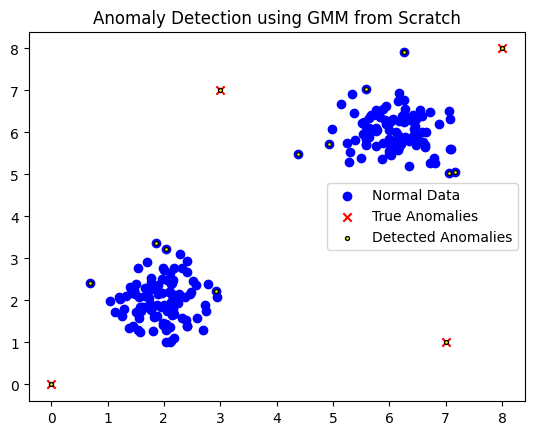

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

# Generate synthetic normal data (2 clusters)
np.random.seed(42)
X_normal = np.vstack([
    np.random.normal(loc=[2, 2], scale=0.5, size=(100, 2)),
    np.random.normal(loc=[6, 6], scale=0.5, size=(100, 2))
])

# Generate some anomalies (outliers)
X_anomalies = np.array([[8, 8], [0, 0], [7, 1], [3, 7]])

# Combine normal and anomalous data for evaluation
X_test = np.vstack([X_normal, X_anomalies])

# Initialize GMM parameters
num_components = 2
dim = X_normal.shape[1]
key = random.PRNGKey(0)

# Randomly initialize means and covariances
means = jnp.array(X_normal[np.random.choice(len(X_normal), num_components, replace=False)])
covariances = jnp.array([jnp.eye(dim) for _ in range(num_components)])
weights = jnp.ones(num_components) / num_components  # Equal weights

# Compute Gaussian probability density function
def gaussian_pdf(X, mean, cov):
    d = X.shape[1]
    det_cov = jnp.linalg.det(cov)
    inv_cov = jnp.linalg.inv(cov)
    norm_factor = jnp.sqrt((2 * jnp.pi) ** d * det_cov)
    diff = X - mean
    exponent = -0.5 * jnp.sum(diff @ inv_cov * diff, axis=1)
    return jnp.exp(exponent) / norm_factor

# Expectation-Maximization (EM) algorithm
def gmm_em(X, num_components, max_iters=100, tol=1e-3):
    global means, covariances, weights
    N = X.shape[0]

    for _ in range(max_iters):
        # Expectation step: Compute responsibilities
        responsibilities = jnp.array([
            weights[k] * gaussian_pdf(X, means[k], covariances[k])
            for k in range(num_components)
        ])
        responsibilities /= responsibilities.sum(axis=0, keepdims=True)

        # Maximization step: Update parameters
        Nk = responsibilities.sum(axis=1)
        new_means = (responsibilities @ X) / Nk[:, None]
        new_covariances = jnp.array([
            ((X - new_means[k]).T @ jnp.diag(responsibilities[k]) @ (X - new_means[k])) / Nk[k]
            for k in range(num_components)
        ])
        new_weights = Nk / N

        # Check convergence
        if jnp.linalg.norm(new_means - means) < tol:
            break

        means, covariances, weights = new_means, new_covariances, new_weights

# Train GMM
gmm_em(X_normal, num_components)

# Compute log-likelihood for each point
log_likelihoods = jnp.log(jnp.sum(jnp.array([
    weights[k] * gaussian_pdf(X_test, means[k], covariances[k])
    for k in range(num_components)
]), axis=0))

# Set anomaly detection threshold (5th percentile of normal log-likelihoods)
threshold = jnp.percentile(log_likelihoods[:len(X_normal)], 5)

# Identify anomalies at threshold
anomalies = X_test[log_likelihoods < threshold]

# Plot results
plt.scatter(X_normal[:, 0], X_normal[:, 1], c='blue', label="Normal Data")
plt.scatter(X_anomalies[:, 0], X_anomalies[:, 1], c='red', marker='x', label="True Anomalies")
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='yellow', marker='o', label="Detected Anomalies", edgecolors='k', s=8)
plt.legend()
plt.title("Anomaly Detection using GMM from Scratch")
plt.show()